# Classifying Structured Data using Keras Preprocessing Layers


## Learning Objectives

* Load a CSV file using [Pandas](https://pandas.pydata.org/).
* Build an input pipeline to batch and shuffle the rows using [tf.data](https://www.tensorflow.org/guide/datasets).
* Map from columns in the CSV to features used to train the model using Keras Preprocessing layers.
* Build, train, and evaluate a model using Keras.

## Introduction

In this notebook, you learn how to classify structured data (e.g. tabular data in a CSV). You will use [Keras](https://www.tensorflow.org/guide/keras) to define the model, and [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) as a bridge to map from columns in a CSV to features used to train the model.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/preprocessing_layers.ipynb).

Note: This tutorial is similar to [Classify structured data with feature columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns). This version uses new experimental Keras [Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) instead of `tf.feature_column`. Keras Preprocessing Layers are more intuitive, and can be easily included inside your model to simplify deployment.

## The Dataset

You will use a simplified version of the PetFinder [dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). There are several thousand rows in the CSV. Each row describes a pet, and each column describes an attribute. You will use this information to predict if the pet will be adopted.

Following is a description of this dataset. Notice there are both numeric and categorical columns. There is a free text column which you will not use in this tutorial.

Column | Description| Feature Type | Data Type
------------|--------------------|----------------------|-----------------
Type | Type of animal (Dog, Cat) | Categorical | string
Age |  Age of the pet | Numerical | integer
Breed1 | Primary breed of the pet | Categorical | string
Color1 | Color 1 of pet | Categorical | string
Color2 | Color 2 of pet | Categorical | string
MaturitySize | Size at maturity | Categorical | string
FurLength | Fur length | Categorical | string
Vaccinated | Pet has been vaccinated | Categorical | string
Sterilized | Pet has been sterilized | Categorical | string
Health | Health Condition | Categorical | string
Fee | Adoption Fee | Numerical | integer
Description | Profile write-up for this pet | Text | string
PhotoAmt | Total uploaded photos for this pet | Numerical | integer
AdoptionSpeed | Speed of adoption | Classification | integer

## Import TensorFlow and other libraries


In [1]:
!pip install -U scikit-learn

**Restart** the kernel before proceeding further (On the Notebook menu, select Kernel > Restart Kernel > Restart).


In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

2024-11-03 19:01:34.428228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 19:01:57.398614: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2024-11-03 19:01:57.398920: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

In [2]:
# print the tensorflow version
tf.__version__

'2.11.0'

## Use Pandas to create a dataframe

[Pandas](https://pandas.pydata.org/) is a Python library with many helpful utilities for loading and working with structured data. You will use Pandas to download the dataset from a URL, and load it into a dataframe.

In [4]:
import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'gs://cloud-training/mlongcp/v3.0_MLonGC/toy_data/petfinder-mini_toy.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
# TODO
# read a comma-separated values (csv) file into DataFrame
dataframe = pd.read_csv(csv_file)

1668792/1668792 [==============================] - 0s 0us/step


In [5]:
# get the first n rows
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


## Create target variable

The task in the Kaggle competition is to predict the speed at which a pet will be adopted (e.g., in the first week, the first month, the first three months, and so on). Let's simplify this for our tutorial. Here, you will transform this into a binary classification problem, and simply predict whether the pet was adopted, or not.

After modifying the label column, 0 will indicate the pet was not adopted, and 1 will indicate it was.

In [6]:
# In the original dataset "4" indicates the pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

## Split the dataframe into train, validation, and test

The dataset you downloaded was a single CSV file. You will split this into train, validation, and test sets.

In [7]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

3199 train examples
800 validation examples
1000 test examples


## Create an input pipeline using tf.data

Next, you will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets), in order to shuffle and batch the data. If you were working with a very large CSV file (so large that it does not fit into memory), you would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

Now that you have created the input pipeline, let's call it to see the format of the data it returns. You have used a small batch size to keep the output readable.

In [15]:
batch_size = 5
# TODO
# call the necessary function with required parameters
train_ds = df_to_dataset(dataframe,shuffle = True, batch_size=batch_size)

In [16]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([12  2 12  2  3], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 1 1 1 1], shape=(5,), dtype=int64)


You can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

## Demonstrate the use of preprocessing layers.

The Keras preprocessing layers API allows you to build Keras-native input processing pipelines. You will use 3 preprocessing layers to demonstrate the feature preprocessing code.

*   [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) - Feature-wise normalization of the data.
*   [`CategoryEncoding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/CategoryEncoding) - Category encoding layer.
*   [`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup) - Maps strings from a vocabulary to integer indices.
*   [`IntegerLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/IntegerLookup) - Maps integers from a vocabulary to integer indices.

You can find a list of available preprocessing layers [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing).

### Numeric columns
For each of the Numeric feature, you will use a Normalization() layer to make sure the mean of each feature is 0 and its standard deviation is 1.

`get_normalization_layer` function returns a layer which applies featurewise normalization to numerical features.

In [17]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

# TODO
# Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [18]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.5069401 , -0.82100594,  0.4352573 , -0.5069401 , -0.82100594],
      dtype=float32)>

Note: If you many numeric features (hundreds, or more), it is more efficient to concatenate them first and use a single [normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer.

### Categorical columns
In this dataset, Type is represented as a string (e.g. 'Dog', or 'Cat'). You cannot feed strings directly to a model. The preprocessing layer takes care of representing strings as a one-hot vector.

`get_category_encoding_layer` function returns a layer which maps values from a vocabulary to integer indices and one-hot encodes the features.

In [19]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

# TODO
  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [21]:
type_col = train_features['Type']
layer = get_category_encoding_layer('Type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>

Often, you don't want to feed a number directly into the model, but instead use a one-hot encoding of those inputs. Consider raw data that represents a pet's age.

In [22]:
type_col = train_features['Age']
category_encoding_layer = get_category_encoding_layer('Age', train_ds,
                                                      'int64', 5)
category_encoding_layer(type_col)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 1.], dtype=float32)>

## Choose which columns to use
You have seen how to use several types of preprocessing layers. Now you will use them to train a model. You will be using [Keras-functional API](https://www.tensorflow.org/guide/keras/functional) to build the model. The Keras functional API is a way to create models that are more flexible than the [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) API.

The goal of this tutorial is to show you the complete code (e.g. mechanics) needed to work with preprocessing layers. A few columns have been selected arbitrarily to train our model.

Key point: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

Earlier, you used a small batch size to demonstrate the input pipeline. Let's now create a new input pipeline with a larger batch size.


In [23]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [24]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [25]:
# Categorical features encoded as integers.
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_encoding_layer('Age', train_ds, dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [26]:
# Categorical features encoded as string.
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


## Create, compile, and train the model


Now you can create our end-to-end model.

In [27]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
# TODO
# compile the model
# TODO: Your code goes here(optimizer='adam',
model.compile(
    optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [28]:
!sudo apt install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-liberation libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin libgvc6
  libgvpr2 liblab-gamut1 libpathplan4
Suggested packages:
  gsfonts graphviz-doc
The following NEW packages will be installed:
  fonts-liberation graphviz libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin
  libgvc6 libgvpr2 liblab-gamut1 libpathplan4
0 upgraded, 11 newly installed, 0 to remove and 2 not upgraded.
Need to get 3034 kB of archives.
After this operation, 11.5 MB of additional disk space will be used.
Get:1 https://deb.debian.org/debian bullseye/main amd64 fonts-liberation all 1:1.07.4-11 [828 kB]
Get:2 https://deb.debian.org/debian bullseye/main amd64 libann0 amd64 1.1.2+doc-7 [25.3 kB]
Get:3 https://deb.debian.org/debian bullseye/main amd64 libcdt5 amd64 2.42.2-5+deb11u1 [62.2 kB]
Get:4 https://deb.debian.org/debian bullseye/main amd64 libcgraph6 

Let's visualize our connectivity graph:


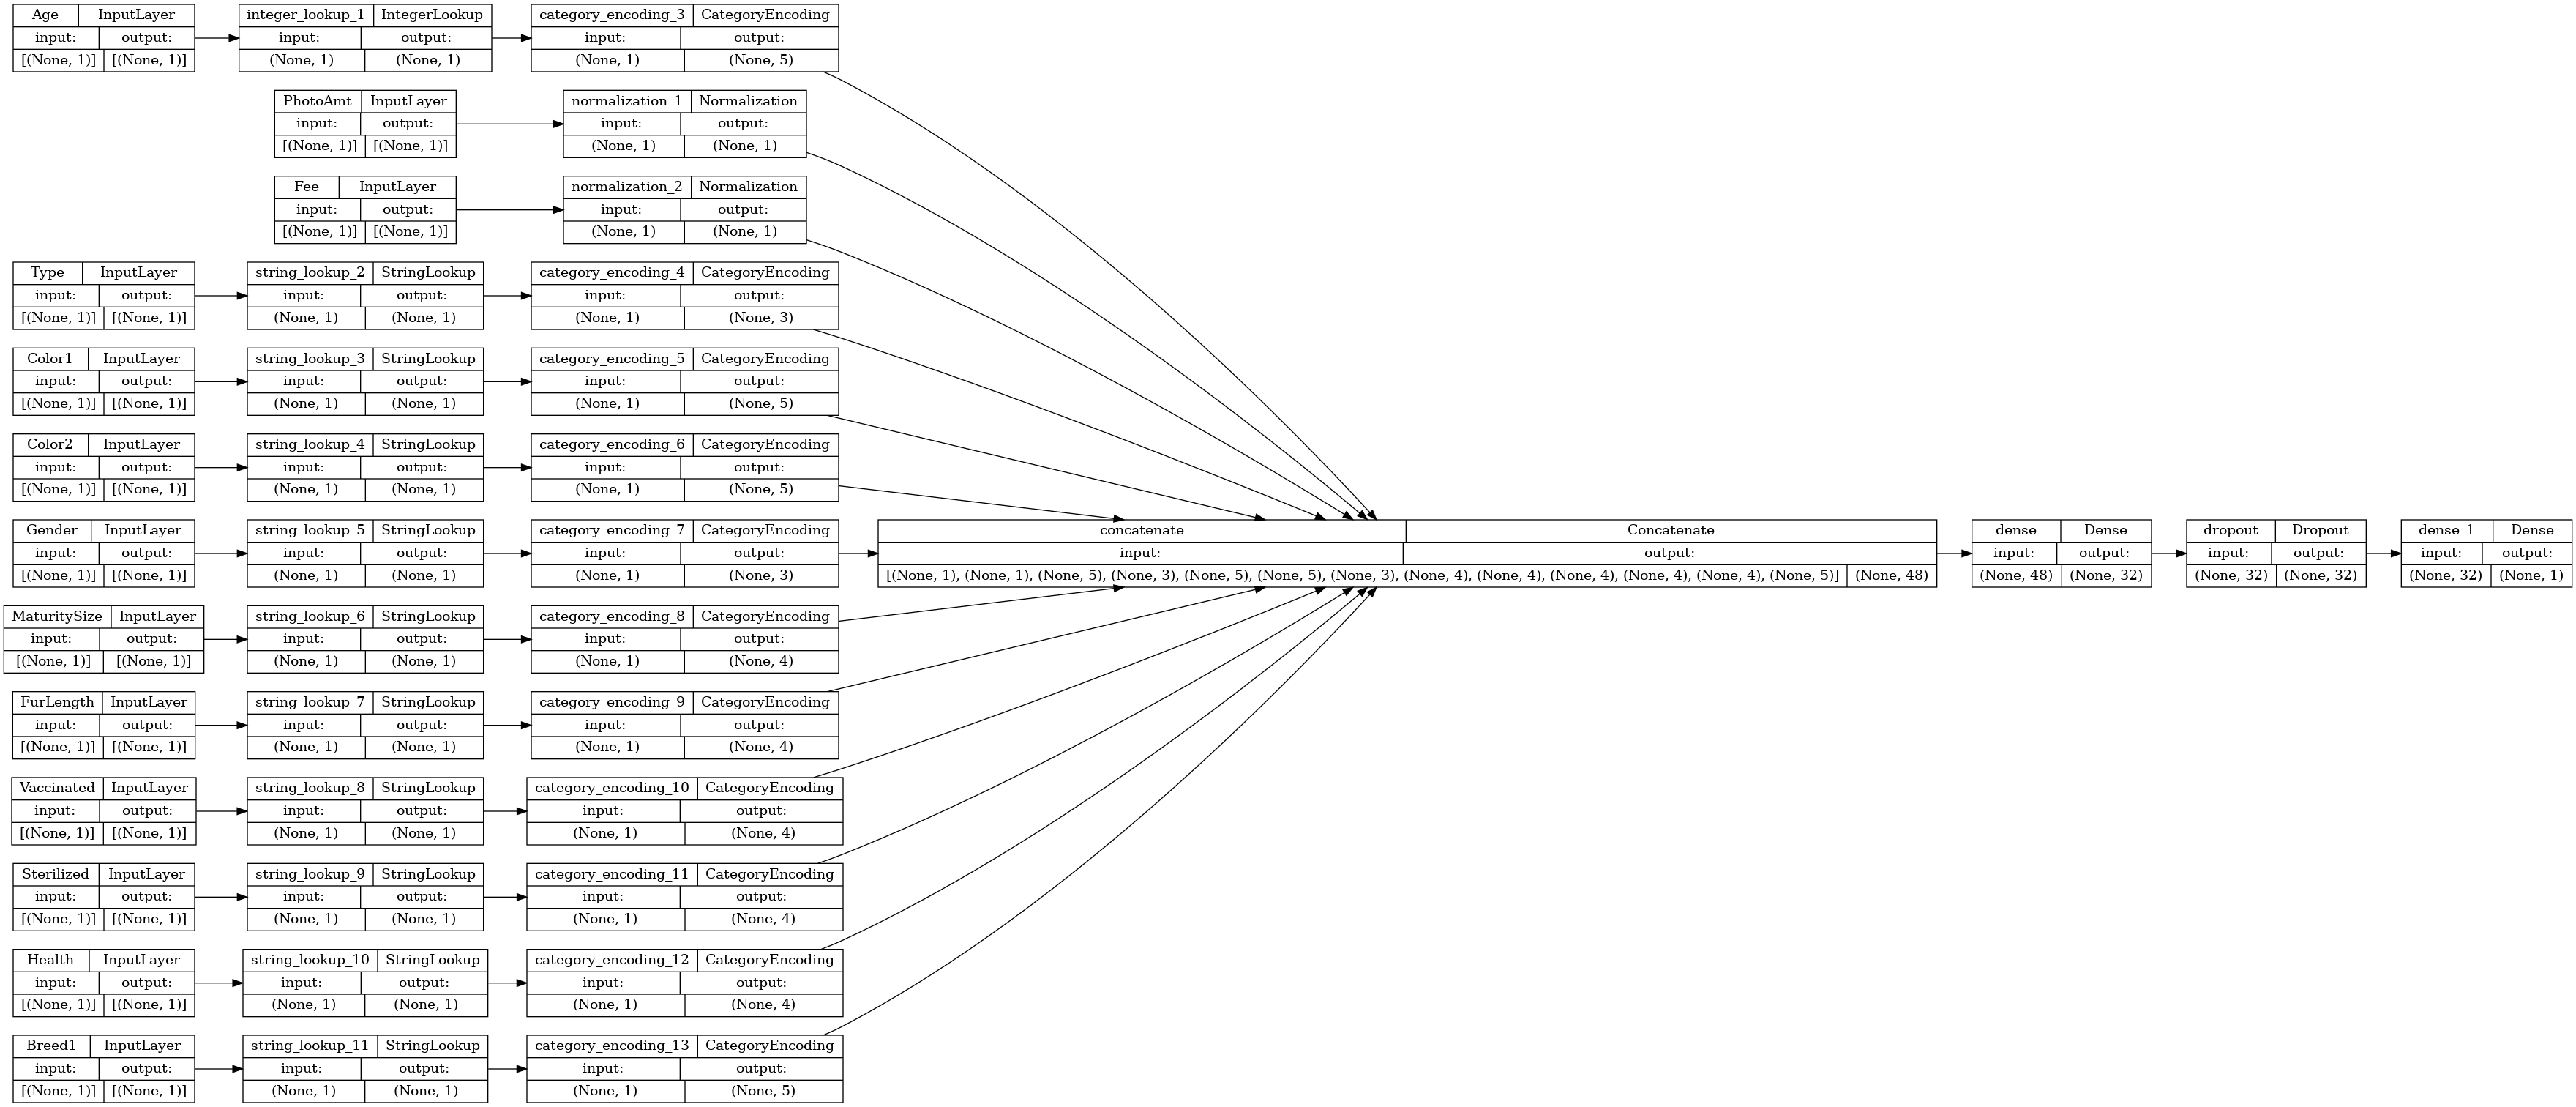

In [29]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


### Train the model


In [30]:
# TODO
# train the model
# TODO: Your code goes here(train_ds, epochs=10, validation_data=val_ds)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
13/13 [==============================] - 4s 51ms/step - loss: 0.6491 - accuracy: 0.5561 - val_loss: 0.5588 - val_accuracy: 0.7262
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 0.6194 - accuracy: 0.6111 - val_loss: 0.5481 - val_accuracy: 0.7437
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 0.6092 - accuracy: 0.6102 - val_loss: 0.5417 - val_accuracy: 0.7450
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 0.6026 - accuracy: 0.6293 - val_loss: 0.5371 - val_accuracy: 0.7375
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 0.5862 - accuracy: 0.6480 - val_loss: 0.5338 - val_accuracy: 0.7300
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 0.5844 - accuracy: 0.6577 - val_loss: 0.5293 - val_accuracy: 0.7350
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 0.5747 - accuracy: 0.6649 - val_loss: 0.5253 - val_accuracy: 0.7350
Epoch 8/10
13/13 [=

In [31]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

4/4 [==============================] - 0s 4ms/step - loss: 0.5546 - accuracy: 0.6920
Accuracy 0.6919999718666077


## Inference on new data

Key point: The model you have developed can now classify a row from a CSV file directly, because the preprocessing code is included inside the model itself.


You can now save and reload the Keras model. Follow the tutorial [here](https://www.tensorflow.org/tutorials/keras/save_and_load) for more information on TensorFlow models.

In [32]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

INFO:tensorflow:Assets written to: my_pet_classifier/assets


INFO:tensorflow:Assets written to: my_pet_classifier/assets


To get a prediction for a new sample, you can simply call `model.predict()`. There are just two things you need to do:

1.   Wrap scalars into a list so as to have a batch dimension (models only process batches of data, not single samples)
2.   Call `convert_to_tensor` on each feature

In [ ]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

Key point: You will typically see best results with deep learning with larger and more complex datasets. When working with a small dataset like this one, we recommend using a decision tree or random forest as a strong baseline. The goal of this tutorial is to demonstrate the mechanics of working with structured data, so you have code to use as a starting point when working with your own datasets in the future.

## Next steps
The best way to learn more about classifying structured data is to try it yourself. You may want to find another dataset to work with, and training a model to classify it using code similar to the above. To improve accuracy, think carefully about which features to include in your model, and how they should be represented.